In [1]:
from jax import numpy as jnp
from jax import vmap, jit
from matplotlib import pyplot as plt

from functools import partial

In [2]:
from scipy.io import loadmat
from dart import fields

x = loadmat("data/map.mat")

gt = fields.GroundTruth(
    jnp.array(x['v'], dtype=float),
    lower=jnp.array([-2.5, -2.5, -2.5]), resolution=jnp.array(10.))

traj = loadmat("data/traj.mat")

In [3]:
from dart import sample
import jax

rmin = 0
rmax = 5
dmin = -5
dmax = 5
sensor = sample.VirtualRadar(
    r=jnp.linspace(rmin, rmax, 50), d=jnp.linspace(dmin, dmax, 50),
    theta_lim=jnp.pi * 0.5, phi_lim=jnp.pi * 0.5)

render = partial(sensor.render, key=jax.random.PRNGKey(42), sigma=gt)
render = jit(vmap(render))
t = (jnp.arange(6 * 6) * traj['velocity'].shape[0] / 36).astype(int)
poses = vmap(sensor.make_pose)(
    jnp.array(traj['velocity'][t]),
    jnp.array(traj['position'][t]),
    jnp.array(traj['orientation'][t]))

In [4]:
import time
start = time.time()
frames = render(pose=poses)
print(time.time() - start)

0.4189901351928711


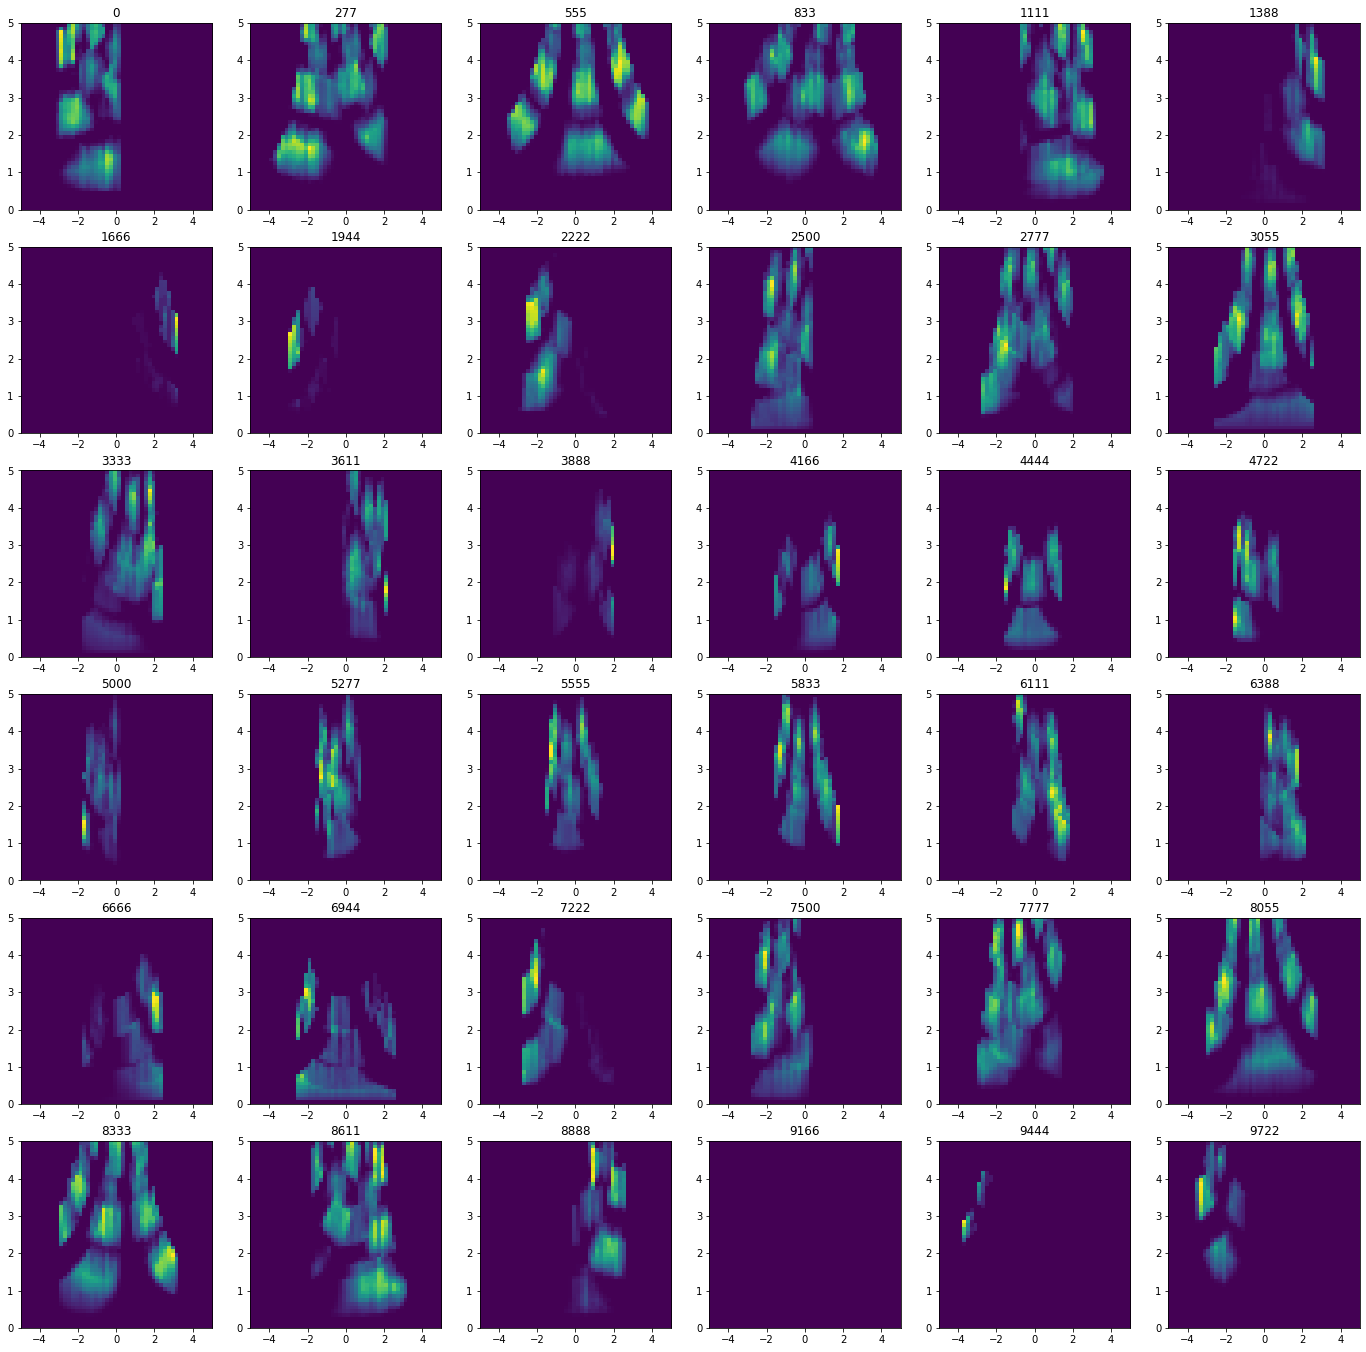

In [5]:
fig, axs = plt.subplots(6, 6, figsize=(24, 24))
axs = axs.reshape(-1)

for i, ax, frame in zip(t, axs, frames):
    ax.imshow(frame, extent=[dmin, dmax, rmin, rmax], aspect='auto', origin='lower')
    ax.set_title(i)

In [ ]:
class NGPHashTable:
    """Single hash table for NGP field.

    References
    ----------
    [1] Muller et al, "Instant Neural Graphics Primitives with a Multiresolution
        Hash Encoding," 2022.
    """

    def __init__(self, size):
        self.size = size

    def hash(self, x):
        """Apply hash function specified by NGP (Eq. 4 [1])"""
        pi2 = 2654435761
        pi3 = 805459861

        return (x[0] + x[1] * pi2 + x[2] * pi3) % self.size